In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import os.path as osp
from tqdm import tqdm_notebook as tqdm
from multi_xgboost import MultiXGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, log_loss
from multi_SHAP import MultiTreeExplainer
import shap

In [2]:
data_dir = r"data\two-sigma-connect-rental-listing-inquiries"
df = pd.read_csv(osp.join(data_dir, "sigma_train_feat_0.01_tfidf_0.05.csv"))

In [3]:
df["created_binned"] = pd.cut(pd.to_datetime(df["created"]), 10, labels=False)

In [18]:
X = df[['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 'created_binned']
       + [col for col in df.columns if "feat" in col or "tfidf" in col]]
y = df['interest_level'].apply(lambda s: 0 if s=="low" else 1 if s=="medium" else 2)
X.columns

Index(['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price',
       'created_binned', 'feat_laundry', 'feat_elevator', 'feat_hardwood',
       'feat_catsallowed',
       ...
       'tfidf_walk', 'tfidf_war', 'tfidf_washer', 'tfidf_water',
       'tfidf_website_redacted', 'tfidf_west', 'tfidf_white', 'tfidf_windows',
       'tfidf_wood', 'tfidf_york'],
      dtype='object', length=256)

In [19]:
# tfidf_cols = [col for col in X.columns if "tfidf" in col]
# X.loc[:, tfidf_cols] = (X.loc[:, tfidf_cols] > 0).astype(int)

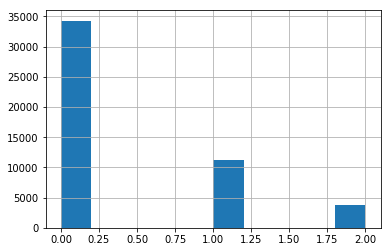

In [21]:
y.hist()

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=34, shuffle=True, stratify=y.values)

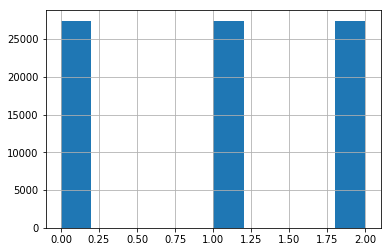

In [23]:
def resample_class_old(cls_inds, max_y):
    return np.random.choice(cls_inds, max_y, replace=True)

def resample_class(cls_inds, max_y):
    rs = np.random.RandomState(34)
    perm = rs.permutation(len(cls_inds))
    cls_inds = cls_inds[perm]
    
    num_reps = int(np.ceil(max_y / len(cls_inds)))
    _resample_inds = np.hstack([cls_inds] * num_reps)
    _resample_inds = _resample_inds[:max_y]
    return _resample_inds
    
y_counts = y_train.value_counts()
max_y = y_counts.max()
resample_inds = []
for cls in y_counts.index:
    cls_inds = np.nonzero((y_train == cls).values)[0]
    _resample_inds = resample_class(cls_inds, max_y)
    resample_inds.extend(_resample_inds)
    
X_train_resample = X_train.iloc[resample_inds]
y_train_resample = y_train.iloc[resample_inds]

y_train_resample.hist()

In [24]:
max_depth = 5
n_estimators = 50
xgb_model = MultiXGBClassifier(max_depth=max_depth, n_estimators=n_estimators,
                               learning_rate=0.1, objective="multi:softmax", verbosity=2)
xgb_model.fit(X_train_resample, y_train_resample)

[20:19:35] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[20:19:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[20:19:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[20:19:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[20:19:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[20:19:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[20:

[20:20:36] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[20:20:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[20:20:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[20:20:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[20:20:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[20:20:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[20:

[20:21:37] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[20:21:39] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[20:21:40] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[20:21:41] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[20:21:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[20:21:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[20:

[20:22:43] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[20:22:44] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[20:22:45] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5


MultiXGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, gamma=0,
          learning_rate=0.1, max_delta_step=0, max_depth=5,
          min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
          nthread=None, objective='multi:softprob', random_state=0,
          reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
          silent=None, subsample=1, verbosity=2)

In [25]:
scores = xgb_model.predict_proba(X_valid)
preds = np.argmax(scores, axis=1)
print("XGBoost classification report:")
print(classification_report(y_valid.values, preds))
print()
print("log_loss:", log_loss(y_valid.values, scores))

XGBoost classification report:
              precision    recall  f1-score   support

           0       0.88      0.69      0.77      6857
           1       0.36      0.48      0.42      2246
           2       0.30      0.60      0.40       768

   micro avg       0.63      0.63      0.63      9871
   macro avg       0.52      0.59      0.53      9871
weighted avg       0.72      0.63      0.66      9871


log_loss: 0.8142036374251889


In [26]:
scores = xgb_model.predict_proba(X_train)
preds = np.argmax(scores, axis=1)
print("XGBoost classification report:")
print(classification_report(y_train.values, preds))
print()
print("log_loss:", log_loss(y_train.values, scores))

XGBoost classification report:
              precision    recall  f1-score   support

           0       0.89      0.70      0.78     27427
           1       0.40      0.52      0.45      8983
           2       0.35      0.72      0.47      3071

   micro avg       0.66      0.66      0.66     39481
   macro avg       0.55      0.65      0.57     39481
weighted avg       0.74      0.66      0.68     39481


log_loss: 0.78636322310606


In [27]:
scores = xgb_model.predict_proba(X_train_resample)
preds = np.argmax(scores, axis=1)
print("XGBoost classification report:")
print(classification_report(y_train_resample.values, preds))
print()
print("log_loss:", log_loss(y_train_resample.values, scores))

XGBoost classification report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70     27427
           1       0.54      0.53      0.53     27427
           2       0.69      0.71      0.70     27427

   micro avg       0.65      0.65      0.65     82281
   macro avg       0.64      0.65      0.65     82281
weighted avg       0.64      0.65      0.65     82281


log_loss: 0.8122608494842763


In [28]:
explainer = MultiTreeExplainer(xgb_model)
shap_values_train = explainer.shap_values(X_train)

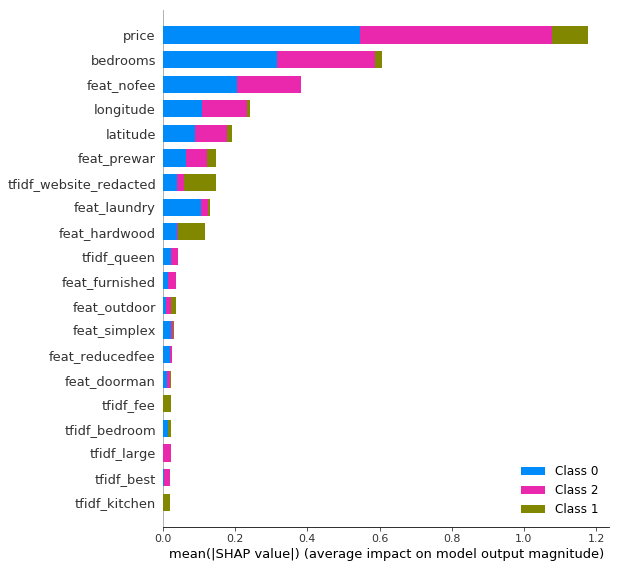

In [29]:
shap.summary_plot(shap_values_train, X_train, plot_type="bar")